In [1]:
%load_ext autoreload
%autoreload 2

## OLS

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import yaml
from pipeline.walkforward import WFCVGenerator
from pipeline.wf_config import WFConfig
from utils.paths import CONFIG_DIR



In [3]:




# -------- load config --------
cfg = yaml.safe_load(open(CONFIG_DIR / "debug.yaml"))

# import wfcv
wf_config = WFConfig(**cfg["walkforward"])

wf = WFCVGenerator(config=wf_config)

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):
    if i > 0:
        break

    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data

In [4]:
import statsmodels.api as sm

# fix a fold
fold = 0

X_tr, y_tr, X_val, y_val, X_test, y_test = data[fold] 

X_tr_const = sm.add_constant(X_tr)
X_test_const = sm.add_constant(X_test)
model = sm.OLS(y_tr, X_tr_const)
results = model.fit(cov_type="HC1")
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     25.63
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           8.18e-96
Time:                        12:02:55   Log-Likelihood:             7.1923e+05
No. Observations:              364349   AIC:                        -1.438e+06
Df Residuals:                  364328   BIC:                        -1.438e+06
Df Model:                          20                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   5.62e-05      2.925      0.0

In [5]:
y_pred_ols = results.predict(X_test_const)
y_pred_ols

array([ 0.00165573, -0.0014846 , -0.00141665, ...,  0.00043378,
       -0.00089082, -0.00061696], shape=(115175,))

R² = -0.0009


/tmp/ipykernel_2296795/407672356.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


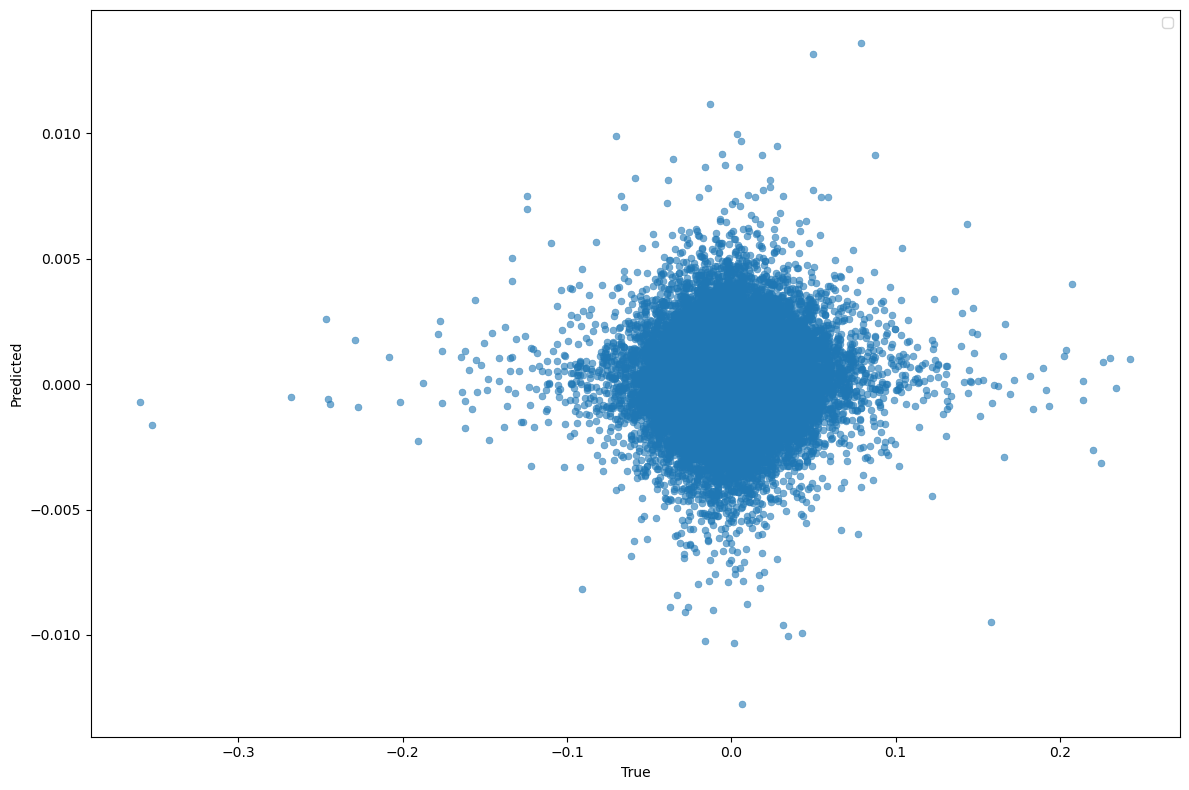

In [6]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_ols)
print(f"R² = {r2:.4f}")

plt.figure(figsize=(12,8))
sns.scatterplot(x=y_test, y=y_pred_ols, s=25, alpha=0.6, edgecolor=None)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()
plt.show()


## Ridge

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import statsmodels.api as sm

# fix a fold
fold = 0

X_tr, y_tr, X_val, y_val, X_test, y_test = data[fold] 

X_tr_const = sm.add_constant(X_tr)
X_test_const = sm.add_constant(X_test)

# --- Define ridge regression (alpha = λ penalty strength) ---
ridge = Ridge(alpha=2, fit_intercept=False)  # intercept already added
ridge.fit(X_tr_const, y_tr)

y_pred_tr_ridge = ridge.predict(X_tr_const)
y_pred_te_ridge = ridge.predict(X_test_const)

r2_train = r2_score(y_tr, y_pred_tr_ridge)
r2_test = r2_score(y_test, y_pred_te_ridge)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_te_ridge))

print(f"R² train: {r2_train:.4f}, R² test: {r2_test:.4f}, RMSE test: {rmse_test:.6f}")

# --- View coefficients (with names if available) ---
coef_names = ["const"] + [f"x{i}" for i in range(X_tr.shape[1])]
for name, coef in zip(coef_names, ridge.coef_):
    print(f"{name:<8} {coef: .6f}")


R² train: 0.0039, R² test: -0.0009, RMSE test: 0.017148
const     0.000164
x0       -0.011912
x1       -0.021484
x2       -0.014487
x3        0.000905
x4        0.018593
x5        0.001307
x6       -0.009751
x7        0.017093
x8        0.012476
x9       -0.001647
x10      -0.016219
x11       0.005134
x12      -0.009627
x13       0.003002
x14      -0.016510
x15      -0.009729
x16      -0.000130
x17       0.003096
x18      -0.034467
x19       0.007574


In [8]:
y_pred_te_ridge

array([ 0.0016495 , -0.00147688, -0.00140913, ...,  0.00043309,
       -0.00088581, -0.00061385], shape=(115175,))

R² = -0.0009


/tmp/ipykernel_2296795/2978607550.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


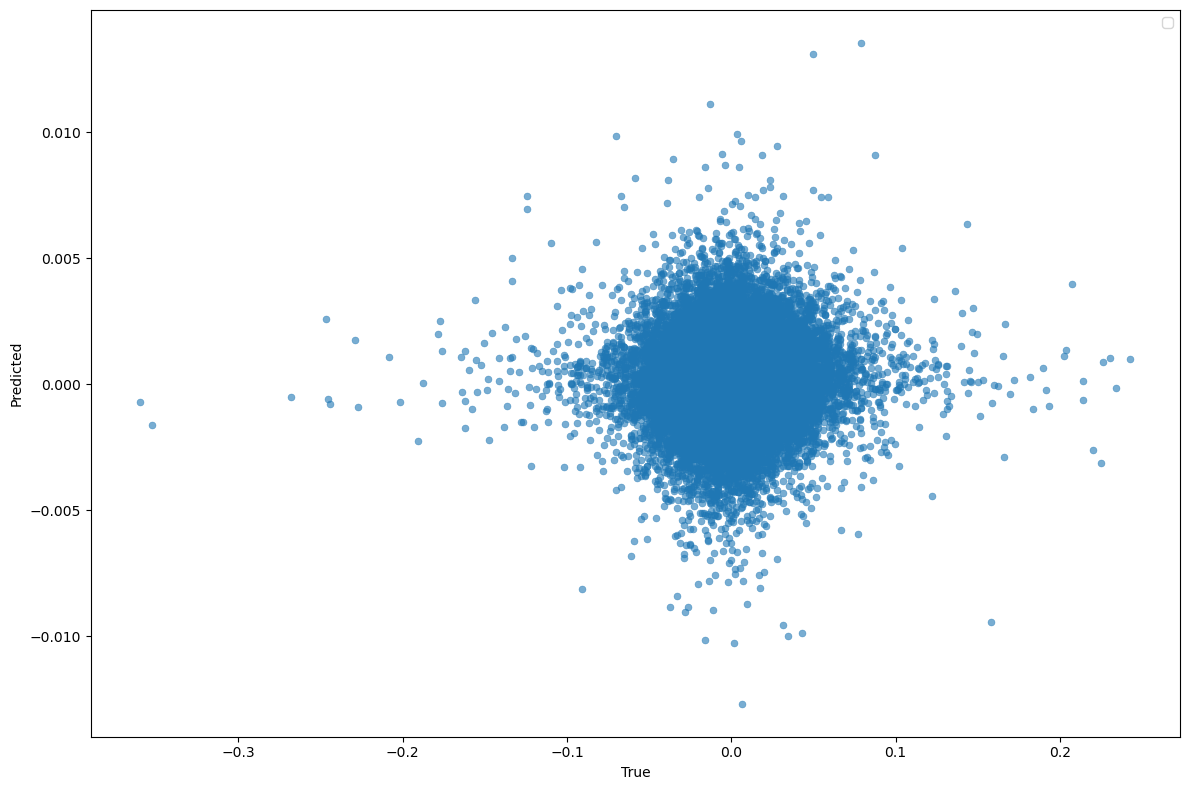

In [9]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred_te_ridge)
print(f"R² = {r2:.4f}")

plt.figure(figsize=(12,8))
sns.scatterplot(x=y_test, y=y_pred_te_ridge, s=25, alpha=0.6, edgecolor=None)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()
plt.show()


## ARIMA